# Variational Quantum Time Evolution (VarQTE) Algorithm based on McLachlan's variational principle

This notebook demostrates how to use Qiskit’s implementation of the Variational Quantum Time Evolution (VarQTE) algorithm for computing the time evolving state under a given Hamiltonian. Specifically, it introduces variational quantum imaginary and real time evolution based on McLachlan's variational principle, and show how this can be leveraged using Qiskit classes.

## Introduction
`VarQTE` is a quantum algorithm that simulates the time evolving state under given Hamiltonian[1]. For a quantum close system's Hamiltonian $H$, the time evolving $\rho$ density matrix follow below equation

$$\frac{d\rho}{dt}=\mathcal{L}\left(\rho\right)$$

where $\mathcal{L}\left(\rho\right)=-i[H,\rho]$ for real time dynamics and $\mathcal{L}\left(\rho\right)=-[H,\rho]$ for imaginary time dynamics. The corresponing state $\psi[\theta(t)]$ is parameterized by time dependent $\theta(t)$. Using McLachlan variational principle, the algorithm updates the parameters by minimize the distance between rigth hand side and left hand side of the equation above. The distance is so called McLachlan's distance $L$ defined as

$$L\equiv\left\Vert \sum_{i}\frac{\partial\rho\left[\theta\right]}{\partial\theta_{i}}\dot{\theta}_{i}-\mathcal{L}\left(\rho\right)\right\Vert _{F}$$

where $\left\Vert M\right\Vert _{F}=\sqrt{M^{\dagger}M}$ is the Frobenius norm of the matrix $M$. The equivalent way is to minimize the squared distance

$$\left\Vert \sum_{i}\frac{\partial\rho\left[\theta\right]}{\partial\theta_{i}}\dot{\theta}_{i}-\mathcal{L}\left(\rho\right)\right\Vert _{F}^{2}=\sum_{i,j}F_{ij}\dot{\theta}_{i}\dot{\theta}_{j}-2\sum_{i}V_{i}\dot{\theta}_{i}+\text{Tr}\left[\mathcal{L}^{2}\left(\rho\right)\right]$$

where

$$F_{ij}=2\text{Re}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{j}}+\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}\left|\psi\left[\theta\right]\right\rangle \left\langle \psi\left[\theta\right]\right|\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{j}}\right]$$,

and

$$V_{i}=\begin{cases}
2\text{Im}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}H\left|\psi\left[\theta\right]\right\rangle +\left\langle \psi\left[\theta\right]\right|\frac{\partial\left|\psi\left[\theta\right]\right\rangle }{\partial\theta_{i}}\left\langle H\right\rangle _{\theta}\right] & \text{Real time}\\
2\text{Re}\left[\frac{\partial\left\langle \psi\left[\theta\right]\right|}{\partial\theta_{i}}H\left|\psi\left[\theta\right]\right\rangle \right] & \text{Imaginary time}
\end{cases}$$.

Minimizing $L^2$ with respect to $\dot{\theta}$ can lead to the equation of motion for $\theta$

$$\sum_{ij}F_{ij}\dot{\theta}_{i}=V_{j}$$

Solving this equation is equivalent to minimizing $L^2$. However, minimizing $L^2$ is more stable in the simulation[2]. $F_{i,j}$ and $V_{j}$ can be calculated using quantum circuit (More details in [1,3]). Thus, the classical computer can minimize $L^2$ to get the varational parameters for next time step. Here, we focus on how to use qiskit to implement `VarQTE` algorithm.

## References:

[1] https://quantum-journal.org/papers/q-2019-10-07-191/

[2] https://arxiv.org/abs/2108.00022

[3] https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030307





## Running VarQTE Algorithm

###Package

In [ ]:
from qiskit.algorithms import TimeEvolutionProblem, VarQITE, VarQTE, VarQRTE, SciPyImaginaryEvolver, SciPyRealEvolver
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple, RealMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2
from qiskit import *
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.primitives import Estimator
import numpy as np
import qiskit
import pylab
from qiskit.algorithms.gradients import ReverseEstimatorGradient, ReverseQGT

In this tutorial, we will use two Qiskit classes, `VarQITE` (variational quantum imaginary time evolution) and `VarQRTE` (variational quantum real time evolution) for time evolutions. We can use a simple Ising model on a spin chain to illustrate this. Let us consider the following Hamiltonian:

$$H = -J\sum_{i=0}^{L-2}Z_{i}Z_{i+1} - h\sum_{i=0}^{L-1}X_i$$

where $J$ stands for the interaction energy, and 
$h$ represents an external field which is orthogonal to the transversal direction. $Z_i$ and $X_i$ are the Pauli operators on the spins. Taking $L=2$, $J=0.2$ and $h =1$, the Hamiltonian and the magnetization $\sum_i Z_i$ can be constructed using `SparsePauliOp`:

In [ ]:
Hamiltonian = SparsePauliOp(['ZZ',  'IX', 'XI'],
              coeffs=[-0.2 , -1, -1])

Magnetization = SparsePauliOp([ 'IZ', 'ZI'], coeffs=[1, 1])

# Imaginary Time Evolution

Imaginary time evolution is usually used to find the ground state or calculate the finite temperature expectation value. Here, we will use qiskit algorithm package `VarQITE` to calculate the ground state energy. First of all, we need to select the ansatz. We can use `EfficientSU2` to fast construct an ansatz, and set up the repetitions by `reps`.

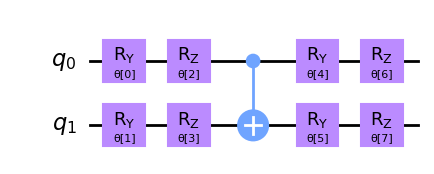

In [ ]:
ansatz = EfficientSU2(Hamiltonian.num_qubits, reps=1) #Select an ansatz
ansatz.decompose().draw('mpl') # Show the circuits of the ansatz

Here, we prepare a dictionary to store the initial parameters we set up. To find the ground state, we just prepare a initial state (decided by the initial parameters) which has overlap with the ground state.

In [ ]:
init_param_values={}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]]=np.pi/2 # initialize the parameters which also decide the initial state

We choose `ImaginaryMcLachlanPrinciple` as the variational principle we'll use later.

In [ ]:
var_principle = ImaginaryMcLachlanPrinciple()  # specify the variational principle

We set target imginary time $t=5$, and set the Hamiltonian as an auxiliary operator. We create `TimeEvolutionProblem` with Hamiltonian, time, and `aux_operators` as arguement. 

In [ ]:
time = 5.0
aux_ops = [Hamiltonian] # adding auxiliary operators
evolution_problem = TimeEvolutionProblem(Hamiltonian, time, aux_operators=aux_ops)

We call the `VarQITE` to calculate the imaginary time evolving state. We can use `VarQITE.evolve` to get the results. Note this cell may take around  $1.5$  minutes to finish.

In [ ]:
%%time
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator()) # Estimator() is necessary, if one want to calculate expectation value of auxiliary operators.
evolution_result = var_qite.evolve(evolution_problem)

CPU times: user 1min 22s, sys: 3.78 s, total: 1min 26s
Wall time: 1min 32s


## Exact Classical Solution
In order to check whether our calculation using `VarQITE` is correct or not. We also call `SciPyImaginaryEvolver` to help us calculate the exact solution. To use `SciPyImaginaryEvolver`, we need to set up the initial state. We use `qiskit.quantum_info.Statevector` to help us get the statevector from the quantum circuit. We set number of time steps as 501.

In [ ]:
init_state=qiskit.quantum_info.Statevector(ansatz.assign_parameters(init_param_values))
evolution_problem=TimeEvolutionProblem(Hamiltonian, time, initial_state=init_state, aux_operators=aux_ops)
exact_evol=SciPyImaginaryEvolver(num_timesteps=501)
sol =exact_evol.evolve(evolution_problem) 

## Result and Comparison

We use `evolution_result.observables` to get expectation value of Hamiltonian varied with time. 

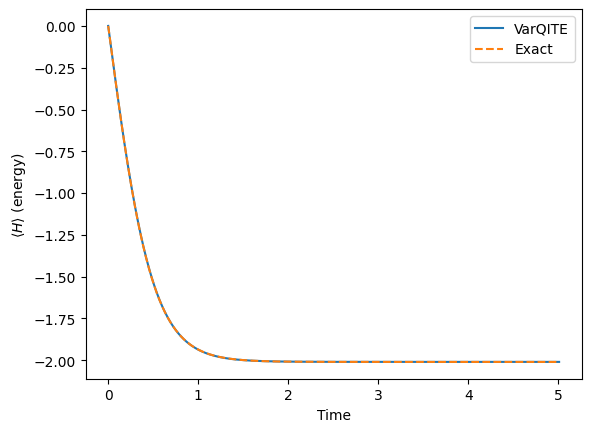

In [ ]:
H_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

Exact_H_exp_val = sol.observables[0][0].real

times = evolution_result.times
pylab.plot(times, H_exp_val, label= "VarQITE")
pylab.plot(times, Exact_H_exp_val , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

In [ ]:
print("Ground state energy",H_exp_val[-1])

Ground state energy -2.0097479079521197


as the above figure indicated, we have obtained the converged ground state energy.

## Efficient Way to run VarQITE

Setting `qpt` as `ReverseQGT()` and `gradient` as `ReverseEstimatorGradient()` can speed up the calculation.

In [ ]:
%%time
var_principle = ImaginaryMcLachlanPrinciple(qgt = ReverseQGT() , gradient = ReverseEstimatorGradient())
evolution_problem = TimeEvolutionProblem(Hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result_ef = var_qite.evolve(evolution_problem) # Take less time

CPU times: user 59 s, sys: 548 ms, total: 59.5 s
Wall time: 1min 1s


It takes only $1$ minute to calculate imaginary time evolution. The execution time reduction is about $33\%$ (it may vary for each execution, but will sppedup in general).

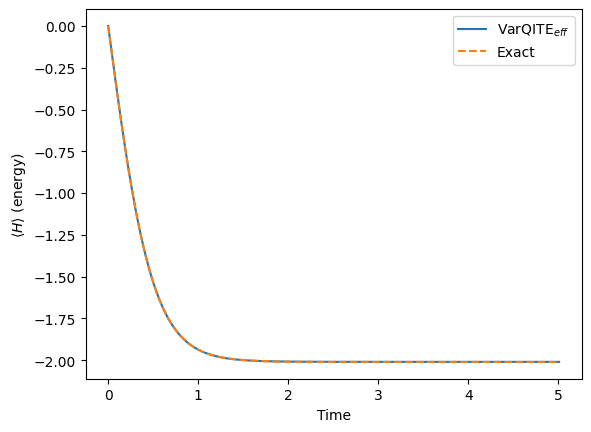

In [ ]:
H_exp_val_ef = np.array([ele[0][0] for ele in evolution_result_ef.observables])

Exact_H_exp_val_ef = sol.observables[0][0].real

times = evolution_result_ef.times
pylab.plot(times, H_exp_val_ef, label= r"VarQITE$_{eff}$")
pylab.plot(times, Exact_H_exp_val_ef , label= "Exact",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

we can also get a converged result, which is consistent with the previous one.

In [ ]:
print("Ground state energy",H_exp_val_ef[-1])

Ground state energy -2.0097479079521183




Let us compare the performance of different methods. The error is defined as the difference between the results in exact solutions and each method.

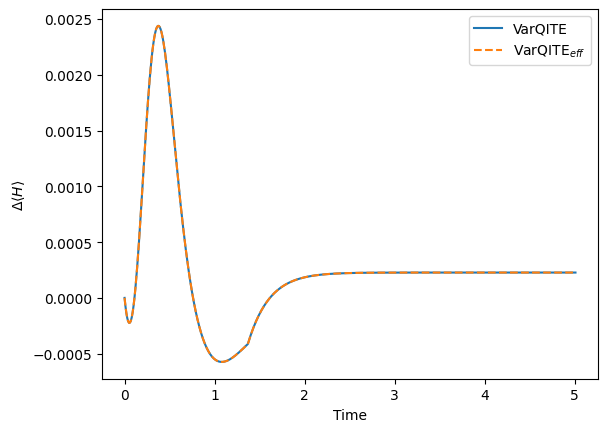

In [ ]:
pylab.plot(times, (H_exp_val-Exact_H_exp_val), label= "VarQITE")
pylab.plot(times, (H_exp_val_ef-Exact_H_exp_val_ef), label= r"VarQITE$_{eff}$",  linestyle='--')
pylab.xlabel("Time")
pylab.ylabel(r"$\Delta \langle H \rangle$")
pylab.legend(loc="upper right");

In this task, the accuracies of `VarQITE` with both gradient methods are almost the same, which makes the `ReverseEstimatorGradient()` more faveroble considering the time efficiency.

We can do the same comparison for `VarQRTE` on simulating the magnetization of the Ising model.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright